# A/B testing

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro
import scipy.stats as stats

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

In [2]:
df=pd.read_csv('ab_test_results_aggregated_views_clicks_6.csv.zip')

In [3]:
df.head()

,user_id,group,views,clicks
0,1,control,3.0,0.0
1,2,control,1.0,0.0
2,3,control,3.0,1.0
3,4,control,5.0,0.0
4,5,control,2.0,0.0


In [6]:
df.shape

(80000, 5)

# Calculation of CTR

In [5]:
df['ctr']=df.clicks/df.views*100
df.head()

,user_id,group,views,clicks,ctr
0,1,control,3.0,0.0,0.000000
1,2,control,1.0,0.0,0.000000
2,3,control,3.0,1.0,33.333333
3,4,control,5.0,0.0,0.000000
4,5,control,2.0,0.0,0.000000


In [11]:
#Checking for null values
df[['user_id', 'group']].nunique()

user_id    80000
group          2
dtype: int64

In [17]:
#Checking for users who can be in both groups (test and control)
df.groupby('user_id')['group'].nunique().value_counts()

1    80000
Name: group, dtype: int64

In [20]:
#Checking for emission values
df.sort_values('ctr', ascending=False)

,user_id,group,views,clicks,ctr
51201,51202,test,1.0,1.0,100.0
54752,54753,test,1.0,1.0,100.0
73575,73576,test,2.0,2.0,100.0
65075,65076,test,1.0,1.0,100.0
37435,37436,control,1.0,1.0,100.0
...,...,...,...,...,...
30587,30588,control,2.0,0.0,0.0
30588,30589,control,4.0,0.0,0.0
30591,30592,control,3.0,0.0,0.0
30592,30593,control,1.0,0.0,0.0


In [58]:
test_group=np.array(df.loc[df.group == 'test', 'ctr'])
control_group=np.array(df.loc[df.group == 'control', 'ctr'])

In [60]:
#Checking for normal distribution with The Shapiro-Wilk test
shapiro(test_group), shapiro(control_group)

(ShapiroResult(statistic=0.5338008403778076, pvalue=0.0),
 ShapiroResult(statistic=0.49946779012680054, pvalue=0.0))

p-value<0.05 - the p-value is low, we can reject a null hypothesis and say that the sample has not been generated from a normal distribution. We need to use a nonparametric test - The Mann-Whitney U test.

In [70]:
#The Mann-Whitney U test
stats.mannwhitneyu(test_group, control_group)

MannwhitneyuResult(statistic=827088703.0, pvalue=5.624709973566946e-26)

p-value<0.05 - we can reject the null hypothesis that the two groups are equal and accept the alternative hypothesis that there is evidence of a difference in average values between the groups.

# Bootstrap

In [75]:
def get_bootstrap(
    column_1,
    column_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
):
    boot_len = max([len(column_1), len(column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    #Calculation of p-value
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    #Visualization
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

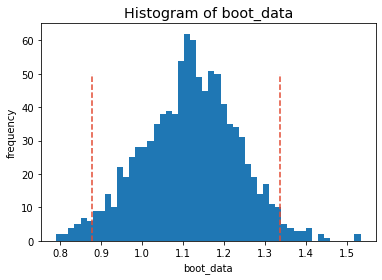

In [78]:
bootstrap_data=get_bootstrap(df.loc[df.group == 'test', 'ctr'], df.loc[df.group == 'control', 'ctr'])

In [79]:
bootstrap_data['ci']

,0
0.025,0.877921
0.975,1.338056


In [80]:
bootstrap_data['p_value']

1.358067745826377e-21

p-value<0.05 - there is evidence of a difference in average values between the groups - the alternative hypothesis is accepted.

# A/B Testing Function - Quick Solution

In [107]:
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "test"][target]
    groupB = dataframe[dataframe[group] == "control"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

# Apply A/B Testing
AB_Test(dataframe=df, group = "group", target = "ctr")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



/Users/victoria/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,5.624710e-26,A/B groups are not similar!
